#### CSCE 670 :: Information Storage & Retrieval :: Texas A&M University :: Spring 2025


# Homework 2:  Ranking with text and links

### 100 points [4% of your final grade]

### Due: February 24 (Monday) by 11:59pm

*Goals of this homework:* In this homework you will focus on the (i) basics of parsing data and graph building; and (ii) basics of PageRank and HITS.

*Submission instructions (Canvas):* To submit your homework, rename this notebook as `UIN_hw2.ipynb`. For example, my homework submission would be something like `555001234_hw2.ipynb`. Submit this notebook via Canvas (look for the homework 2 assignment there). Your notebook should be completely self-contained, with the results visible in the notebook. We should not have to run any code from the command line, nor should we have to run your code within the notebook (though we reserve the right to do so). So please run all the cells for us, and then submit.

*Late submission policy:* For this homework, you may use as many late days as you like (up to the 5 total allotted to you).

*Collaboration policy:* You are expected to complete each homework independently. Your solution should be written by you without the direct aid or help of anyone else. However, we believe that collaboration and team work are important for facilitating learning, so we encourage you to discuss problems and general problem approaches (but not actual solutions) with your classmates. You may post on Canvas, search StackOverflow, even use ChatGPT. But if you do get help in this way, you must inform us by **filling out the Collaboration Declarations at the bottom of this notebook**. See the course syllabus for details.

*Example: I found helpful code on stackoverflow at https://stackoverflow.com/questions/11764539/writing-fizzbuzz that helped me solve Problem 2.*

The basic rule is that no student should explicitly share a solution with another student (and thereby circumvent the basic learning process), but it is okay to share general approaches, directions, and so on. If you feel like you have an issue that needs clarification, feel free to contact either me or the TA.

# Dataset: Enron Email Dataset

We are providing you with a collection of emails from the Enron Email Dataset. The Enron Email Dataset was collected and prepared by the CALO Project (A Cognitive Assistant that Learns and Organizes). It contains data from about 150 users, mostly senior management of Enron. The full corpus contains a total of about 0.5M messages (https://www.cs.cmu.edu/~enron/).

For this homework, we will use a subset of the dataset. The subset contains the `sent emails` from 78 users in the dataset. We have zipped the dataset and provided it to you on Canvas as `enron_sent_mail.zip`. The zip file is about 45 MB. Each folder contains a subfolder named `_sent_mail` which contains the sent emails of that user. Each email is stored in a separate file, containing the relationship of `who send to whom` as noted by `From:` and `To:` entries. We are going to build a graph using the relationships between the users!


Below is an example of one email.

```text
Message-ID: <33025919.1075857594206.JavaMail.evans@thyme>
Date: Wed, 13 Dec 2000 13:09:00 -0800 (PST)
From: john.arnold@enron.com
To: slafontaine@globalp.com
Subject: re:spreads
Mime-Version: 1.0
Content-Type: text/plain; charset=us-ascii
Content-Transfer-Encoding: 7bit
X-From: John Arnold
X-To: slafontaine@globalp.com @ ENRON
X-cc:
X-bcc:
X-Folder: \John_Arnold_Dec2000\Notes Folders\'sent mail
X-Origin: Arnold-J
X-FileName: Jarnold.nsf

saw a lot of the bulls sell summer against length in front to mitigate
margins/absolute position limits/var.  as these guys are taking off the
front, they are also buying back summer.  el paso large buyer of next winter
today taking off spreads.  certainly a reason why the spreads were so strong
on the way up and such a piece now.   really the only one left with any risk
premium built in is h/j now.   it was trading equivalent of 180 on access,
down 40+ from this morning.  certainly if we are entering a period of bearish
to neutral trade, h/j will get whacked.  certainly understand the arguments
for h/j.  if h settles $20, that spread is probably worth $10.  H 20 call was
trading for 55 on monday.  today it was 10/17.  the market's view of
probability of h going crazy has certainly changed in past 48 hours and that
has to be reflected in h/j.




slafontaine@globalp.com on 12/13/2000 04:15:51 PM
To: slafontaine@globalp.com
cc: John.Arnold@enron.com
Subject: re:spreads



mkt getting a little more bearish the back of winter i think-if we get another
cold blast jan/feb mite move out. with oil moving down and march closer flat
px
wide to jan im not so bearish these sprds now-less bullish march april as
well.
```

# Part 1: Parse the Email Data to Build a Graph (50 points)

---

Recall how we parse the email content in HW1. Now, in this part, we're going to parse the dataset to build a graph. So, instead of viewing the world as web pages with hyperlinks (where pages = nodes, hyperlinks = edges), we view it as users in an email network. Over this graph, we can apply classic methods like PageRank and Hubs-and-Authorities to order the users according to some notion of importance.

For the first part, you will complete the following code to construct the graph based on the given data. In this graph, the node is the user and a link between two users is added if user A sent an email to user B. The weight of the link is the number of emails sent between user A and user B.

You will need to write a python code to loop through each email file and extract the sender and receiver of each email.
Specifically, you should extract the sender from the `From: john.arnold@enron.com` and receiver from the `To: slafontaine@globalp.com` fields at the top of each email.

* Use the email address to represent a unique user.
* Remove any space in the email. User lower case for the email address.
* Only extract the email addresses that are in the `From:` and `To:` fields at the top of the email. If the email contains forwarded emails below, you can ignore them.
* Choose a proper data structure to store the unique users and the number of times they appear in the dataset. We will use it to build a graph later.

### Print the number of total emails (5 points)

In [146]:
import re
email_history={'sent_count':0}
def extract_ids(email: str):
    # Extract the part before "Subject:"

    header_part = re.split(r"^Subject:.*", email, flags=re.MULTILINE)[0]
    
    # Extract sender email (From: ...)
    from_match = re.search(r"^From:\s*(\S+@\S+)", header_part, re.MULTILINE)
    sender_email = from_match.group(1) if from_match else None
    # Extract receiver email(s) (To: ... may span multiple lines)
    to_match = re.search(r"^To:\s*((?:.+\n?)+?)\n{1,2}", header_part, re.MULTILINE)
    if from_match and to_match:
        email_history['sent_count']+=1
    else: None

    if to_match:
        receiver_text = to_match.group(1)
        receiver_emails = re.findall(r"[\w._%+-]+@[\w.-]+\.[a-zA-Z]{2,}", receiver_text)
    else:
        receiver_emails = []
    if sender_email not in email_history:
        email_history[sender_email]=[0,0]
    email_history[sender_email][0]+=1
    for receiver_email in receiver_emails:
        if receiver_email not in email_history:
            email_history[receiver_email]=[0,0]
        email_history[receiver_email][1]+=1
    return  sender_email, receiver_emails

In [147]:
# your code here

import os
sender_counts={}
emails_dict={}
emails_sent=0

for user in os.listdir("enron_sent_mail"):
    if user=='.DS_Store':
      continue
    for files in os.listdir("enron_sent_mail/" + user):
        if files=='.DS_Store':
          continue
        for emails in os.listdir("enron_sent_mail/" + user + "/" + files):
          if emails=='.DS_Store':
            continue
          if files == '_sent_mail':
            with open("enron_sent_mail/" + user + "/" + files + "/" + emails, 'r') as f:
              lines = f.read()
              sender, receivers=extract_ids(lines)
              # emails_sent+=1
              if sender not in emails_dict:
                emails_dict[sender] = []
              for receiver in receivers:
                emails_dict[sender].append(receiver)
              


In [148]:
# print(len(emails_dict))
# print(email_history['vkaminski@aol.com'])

print("No.of Emails:",email_history['sent_count'])
email_history.pop('sent_count', None)


No.of Emails: 30034


30034

### Print the number of unique users (5 points)

In [ ]:
print("No.of Unique Users:",len(email_history))


No.of Unique Users: 7003


In [183]:
diff=[]
with open("C:/Users/SUJITH/Downloads/test.txt") as f:
    k=f.readlines()
    # print(k[:-2])
    for id in k:
        diff.append(id[:-1]) if id[:-1] not in email_history.keys() else None

In [186]:
print(len(diff))
print(diff)

23
["maura.o'neil@enron.com", "d'arcy.carroll@enron.com", 'et&s.office@enron.com', "angie.o'brian@enron.com", "'lerea.pharr'@enron.com", "tim.o'rourke@enron.com", "o'neal.winfree@enron.com", "randy.o'connor@enron.com", "'gayle.rodgers@enron.com", "kenneth.d'silva@enron.com", "justin.o'malley@enron.com", "brian.o'rourke@enron.com", "tom.o'donnell@enron.com", 'tropicair@btl.n', "ryan.o'rourke@enron.com", 'enron.everyone_et&s_houston@enron.com', "murray.o'neil@enron.com", '/o=enron@enron.com', "paul.d'arcy@enron.com", '/ou=hou/o=ect@enron.com', "karon.o'gorman@enron.com", "virginia.o'neill@enron.com", 'enron.everyone_et&s_field_offices@enron.com']


### Print the top-5 users ranked by the number of emails they involved in the dataset (5 points)

For example, email 1 we have user A sent to user B, email 2 we have user C sent to user A. Then, user A is involved in 2 emails, user B and C are involved in 1 email. So, the top users are A, B, C.

Your output should look like this:

```text
user emails_involved
john.arnold@enron.com 100
slafontaine@globalp.com 98
......
```

In [150]:
involved=defaultdict(int)
for key in email_history:
  involved[key]=email_history[key][0]+email_history[key][1]

top_5_involved=sorted(involved.items(), key=lambda x: x[1], reverse=True)[:5]
print("Top 5 involved users:")
for i in range(5):
  print(top_5_involved[i][0],":",top_5_involved[i][1])

  

Top 5 involved users:
kay.mann@enron.com : 4231
vince.kaminski@enron.com : 3527
chris.germany@enron.com : 1695
eric.bass@enron.com : 1453
kate.symes@enron.com : 1341


### Print the top-5 users who sent out the most emails in the dataset (5 points)

Note that here, we only consider the person who sent the email, not the receiver.

Your output should look like this:

```text
user emails_sent
john.arnold@enron.com 100
slafontaine@globalp.com 98
......
```

In [151]:
sorted_emails = sorted(email_history.items(), key=lambda x: x[1][0], reverse=True)

# Print top 5
print("Top 5 sent users:")
for email, values in sorted_emails[:5]:
    print(f"{email}: {values[0]}")

Top 5 sent users:
kay.mann@enron.com: 4220
vince.kaminski@enron.com: 3464
chris.germany@enron.com: 1658
eric.bass@enron.com: 1409
kate.symes@enron.com: 1323


### Print the top-5 users who received the most emails in the dataset (5 points)

Note that here, we only consider the receiver, not sender.

Your output should look like this:

```text
user emails_received
john.arnold@enron.com 100
slafontaine@globalp.com 98
......
```

In [152]:
sorted_emails = sorted(email_history.items(), key=lambda x: x[1][1], reverse=True)[:5]

# Print top 5
print("Top 5 received users:")
for email, values in sorted_emails:
    print(f"{email}: {values[1]}")

Top 5 received users:
vkaminski@aol.com: 1061
suzanne.adams@enron.com: 428
shirley.crenshaw@enron.com: 304
nmann@erac.com: 285
john.lavorato@enron.com: 272


### Let's build the graph! (15 points)

Here we are going to use the `networkx` library to build the graph. You can install the library by running `!pip install networkx`.

We are going to build an `undirected` graph (regardless of who sent to whom). The nodes of the graph are the users (represented by the unique email address) and the edges are the emails sent between the users. The weight of the edge is the number of emails sent between the users.

For example, if user A sent 3 emails to user B, and user B sent 2 emails to user A, then the weight of the edge between A and B is 3+2=5.

In [153]:
!pip install networkx

In [8]:
import networkx as nx
import matplotlib.pyplot as plt
import json
from tqdm import tqdm

In [156]:
# your code to parse the emails to get the nodes, edges, and weights
# tips: think about what data structure you should use to efficiently collect the information by only looping through the entire dataset once. Consider sets, lists, dictionaries, etc.
pairs={}
for sender in emails_dict:
    for receiver in emails_dict[sender]:
        if (sender,receiver) not in pairs and (receiver,sender) not in pairs:
            pairs[(sender,receiver)]=0
        if (sender,receiver) in pairs:
            pairs[(sender,receiver)]+=1
        elif (receiver,sender) in pairs:
            pairs[(receiver,sender)]+=1


In [158]:
print(len(pairs))

11225


In [ ]:
# your code to create the graph
# note the following is a sample code for illustrating how to build the graph
# feel free the modify the code to suit your needs


G = nx.Graph()
unique_users = email_history.keys()
for user in unique_users:
    G.add_node(user)

# Add edges based on emails your parsed
users = list(unique_users)  # List of users for iteration
# for i in tqdm(range(len(users)), desc="Processing users"):
#         if xxx:
#             # Add an edge between users if they have a common email
#             G.add_edge(user_A, user_B, weight=number_of_common_emails)
for pair in pairs:
    G.add_edge(pair[0],pair[1], weight=pairs[pair])
print(G)

Graph with 7003 nodes and 11225 edges


### Visualization of the graph (5 points)

Now you have built the graph. Let's visualize the graph. Use any package you like to visualize the graph.

You can find some examples here: https://networkx.org/documentation/stable/auto_examples/index.html

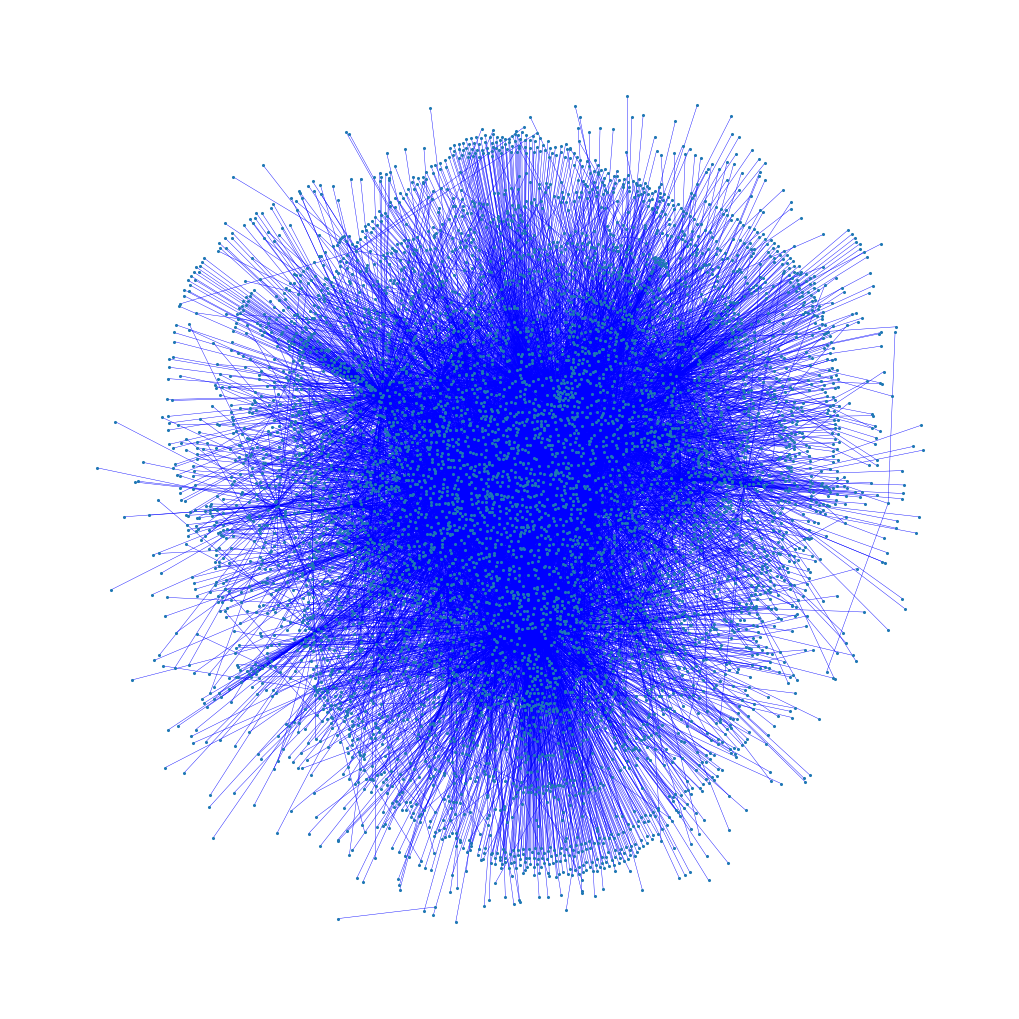

In [164]:
import matplotlib.pyplot as plt
import networkx as nx

pos = nx.spring_layout(G, k=0.1, iterations=50)  # Adjust 'k' for spacing

options = {
"node_size": 5,  
"edge_color": "blue",
"linewidths": 0,
"width": 0.3,  
}

plt.figure(figsize=(10, 10))  # Increase figure size
nx.draw(G, pos, **options)

plt.axis("off")
plt.show()


### Observation of the graph (5 points)

What can you observe from the graph? Is there any user who is the center of the graph? Is there any user who is isolated from the graph? Which node has the most edges? Please provide your observations in bullet points based on the visualization.

Your output should look like this:

```text
* Observation 1:As the center of the graph is very dense, we can say that a lot of email exchanges have happened between those people
* Observation 2:Circumference of the circle consists of many users, who are not involved in much email exchanges
* Observation 3:We can seperate people who are at the center of circle as the people who are involved or most prominent and the people who are at the circumference of the graph as people who do not involve in email exchanges a lot and thus, less prominent

```

*your discussion here*

# Part 2: Link-based Ranking (50 points)

---

In this part, over the graph you built, we're going to adapt the classic PageRank and  Hubs-and-Authorities approaches to allow us to find the most important users. So, instead of viewing the world as web pages with hyperlinks (where pages = nodes, hyperlinks = edges), we view it as users in an email network.


### A: PageRank (10 points)
Given this graph, your first job is to simply run PageRank to find the highest ranking users. You may use the [built-in pagerank](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.link_analysis.pagerank_alg.pagerank.html) function in networkx.

Print the top-5 highest PageRank scores in `user: score` format.

In [171]:
# your code here
Ranking = nx.pagerank(G,0.85)

sorted_ranking = sorted(Ranking.items(), key=lambda x: x[1], reverse=True)
print("Top 5 users based on PageRank:") 
top_5=sorted_ranking[:5]
for i in range(5):
  print(top_5[i][0],":",top_5[i][1])

Top 5 users based on PageRank:
vince.kaminski@enron.com : 0.03965623219284268
kay.mann@enron.com : 0.02911951544068796
sally.beck@enron.com : 0.02834122656980458
jeff.skilling@enron.com : 0.027921339987200314
mary.hain@enron.com : 0.024870419515831212


### B: Personalized PageRank (10 points)
In class, we focused on the traditional "vanilla" PageRank where the teleportation factor is uniform -- that is, the random surfer occasionally is bored and will teleport randomly to a node in the graph. Instead, we can bias the teleportation to a subset of nodes in the graph. This is called Personalized PageRank! The idea is that the PageRank scores will be biased towards nodes near the ones that you teleport to.

For this problem assume the user of interest is `"john.arnold@enron.com"`. You should compute the personalized PageRank and print the top-5 highest personalized PageRank scores in `user: score` format. Note that there is a nice function parameter called "personalization" in the built-in pagerank that you can use for this problem.

In [ ]:

import networkx as nx

user_of_interest = "john.arnold@enron.com"

personalization = {node: (1 if node == user_of_interest else 0) for node in G.nodes()}
personalized_ranking = nx.pagerank(G, alpha=0.85, personalization=personalization)
sorted_personalized_ranking = sorted(personalized_ranking.items(), key=lambda x: x[1], reverse=True)

print("Top 5 users based on Personalized PageRank:")
top_5_personalized = sorted_personalized_ranking[:5]
for user, score in top_5_personalized:
    print(f"{user}: {score}")


Top 5 users based on Personalized PageRank:
john.arnold@enron.com: 0.2574032165650228
john.lavorato@enron.com: 0.02482944308237426
vince.kaminski@enron.com: 0.023631156776886892
sally.beck@enron.com: 0.01727752349777198
kay.chapman@enron.com: 0.016467146303507797


### C: Hubs and Authorities (20 points)
Just like we can calculate PageRank over the user graph, we can also find the hub and authority scores for users.

For this part, you should return the top-5 users with highest Hub scores and the top-5 users with the highest Authority scores. The **output** should be like:

`Hub Scores`

`1. user1: score1`

`...`

`Authority Scores`

`1. user1: score1`

` ...`




In [173]:
# Your code here
hits=nx.hits(G, max_iter=100)
hubs_sorted=sorted(hits[0].items(), key=lambda x:x[1], reverse=True)
top_5_hubs=hubs_sorted[:5]
print("Top 5 Hubs:")
for key, value in top_5_hubs:
    print(f"{key}: {value}")
authorities_sorted=sorted(hits[1].items(), key=lambda x:x[1], reverse=True)
top_5_auth=authorities_sorted[:5]
print("Top 5 Authorities:")
for key, value in top_5_hubs:
    print(f"{key}: {value}")


Top 5 Hubs:
vince.kaminski@enron.com: 0.22388822277816428
vkaminski@aol.com: 0.2086693245364656
shirley.crenshaw@enron.com: 0.059595289635956894
stinson.gibner@enron.com: 0.023412536036604852
mike.roberts@enron.com: 0.010822878614481776
Top 5 Authorities:
vince.kaminski@enron.com: 0.22388822277816428
vkaminski@aol.com: 0.2086693245364656
shirley.crenshaw@enron.com: 0.059595289635956894
stinson.gibner@enron.com: 0.023412536036604852
mike.roberts@enron.com: 0.010822878614481776


### Discussion (10 points)
Briefly discuss the differences you see between the three methods. You should play with the personalization parameters in PageRank and show some findings.


*your discussion here*
* The scores for Hubs and Authorites are same for a user as the graph is an undirected graph
* Page rank is a global and unifrom ranking which is unbiased, whereas personalized page rank is a biased ranking which targets specific nodes.
* In page rank and personalized page rank, we will get single score per user, whereas in hubs and authorities we will get two scores per user, but as the graph is undirected, both the scores are same for a specified user.
* Hubs and authorities is a link based ranking
* 

# Collaboration Declarations

*You should fill out your collaboration declarations here.*
I used GPT for syntax issues while doing sorting using lambda functions